# Assignment 5

**Course**: AM5801 - Computational Lab  
**Name**: Atharv Shete  
**Roll No**: BE22B021

## Question 1

### Randomized Load Balancing Algorithm

In this question, we design and implement a randomized load balancing algorithm for a large-scale cloud data center with the following specifications:

- **n** servers (up to 10^4)
- **m** incoming computational tasks (up to 10^7)
- Each task has:
  - A unique ID
  - A computational weight (randomly generated between 1 and 1000 CPU units)
  - A priority level: High, Medium, or Low (balanced mix)
- The data center has a fixed total CPU capacity.
- **Goal:** Assign tasks to servers such that:
  - Load is balanced as evenly as possible
  - Number of overloaded servers is minimized
  - Overall system throughput is maximized

**Algorithm:**

For each incoming task, two servers are selected uniformly at random, and the task is assigned to the server with the lesser current load (the "power of two choices" strategy). Efficient data structures are used to track server loads and ensure scalability.

**Performance Metrics to Report:**

- Maximum server load
- Average load per server
- Standard deviation of server load distribution
- Histogram of the load distribution
- Number of servers whose load exceeds a threshold (e.g., 1.5 times average expected load)

The following cells implement the algorithm and report the required metrics.

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

n = 10_000  
m = 10_000_000 
# Generate random tasks
task_ids = np.arange(m)
task_weights = np.random.randint(1, 1001, size=m)
priority_levels = np.random.choice(['High', 'Medium', 'Low'], size=m, p=[1/3, 1/3, 1/3])

# Initialize server loads
server_loads = np.zeros(n, dtype=np.int64)

# Randomized load balancing (power of two choices)
for i in range(m):
    s1, s2 = random.sample(range(n), 2)
    if server_loads[s1] <= server_loads[s2]:
        server_loads[s1] += task_weights[i]
    else:
        server_loads[s2] += task_weights[i]

In [9]:
# Compute performance metrics
max_load = np.max(server_loads)
avg_load = np.mean(server_loads)
std_load = np.std(server_loads)

# Expected average load if tasks are evenly distributed
expected_avg_load = np.sum(task_weights) / n
threshold = 1.5 * expected_avg_load
overloaded_servers = np.sum(server_loads > threshold)

print(f"Maximum server load: {max_load}")
print(f"Average load per server: {avg_load:.2f}")
print(f"Standard deviation of server load: {std_load:.2f}")
print(f"Expected average load (theoretical): {expected_avg_load:.2f}")
print(f"Overload threshold (1.5x expected avg): {threshold:.2f}")
print(f"Number of overloaded servers (>1.5x expected avg): {overloaded_servers}")

Maximum server load: 502338
Average load per server: 500538.74
Standard deviation of server load: 601.30
Expected average load (theoretical): 500538.74
Overload threshold (1.5x expected avg): 750808.11
Number of overloaded servers (>1.5x expected avg): 0


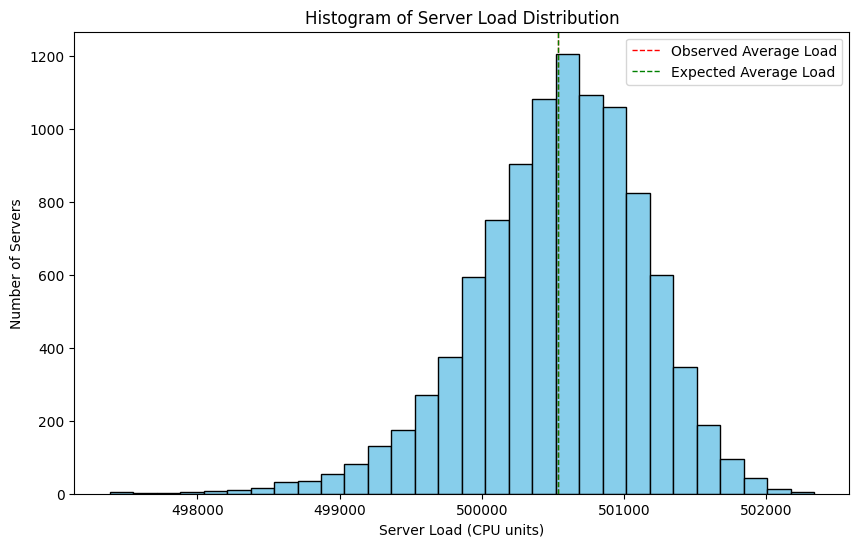

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(server_loads, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Server Load Distribution')
plt.xlabel('Server Load (CPU units)')
plt.ylabel('Number of Servers')
plt.axvline(avg_load, color='red', linestyle='dashed', linewidth=1, label='Observed Average Load')
plt.axvline(expected_avg_load, color='green', linestyle='dashed', linewidth=1, label='Expected Average Load')
plt.legend()
plt.show()

## Question 2

### Gradient Descent Optimization for Urban Traffic Signal Timing

In this question, we address the problem of minimizing the total average vehicle delay at a network of city intersections by optimizing the green light durations for each signal phase. The delay function is nonlinear and differentiable, making analytical optimization infeasible due to high dimensionality and complex interactions.

We use a **Gradient Descent** algorithm to iteratively update the green times, minimizing the total average delay. The algorithm allows specification of the learning rate and number of iterations, and outputs the optimized green times, total delay before and after optimization, and a convergence graph.

**Why Gradient Descent?**
- Analytical solutions are impractical for high-dimensional, nonlinear systems.
- Gradient Descent efficiently finds local minima by following the direction of steepest descent, making it suitable for large-scale optimization.
- The learning rate controls the step size: too high can cause divergence, too low slows convergence.

The following cells implement the algorithm and report the required results.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

num_intersections = 10  # Number of intersections
phases_per_intersection = 3  # Number of signal phases per intersection
num_phases = num_intersections * phases_per_intersection

# Initial feasible green times (seconds)
green_times = np.full(num_phases, 30.0)  # Start with 30s for each phase

# Example nonlinear, differentiable delay function (black-box)
def total_delay(green_times):
    # Delay increases if green time is too short or too long
    min_green, max_green = 10.0, 90.0
    optimal_green = 40.0
    # Soft penalties for feasibility outside [10, 90]
    penalty = np.sum(np.maximum(min_green - green_times, 0.0)**2)
    penalty += np.sum(np.maximum(green_times - max_green, 0.0)**2)
    # Nonlinear smooth delay term
    delay_terms = (green_times - optimal_green)**2 + 1000.0 / (green_times + 1.0)
    return np.sum(delay_terms) + 10.0 * penalty

# Analytic gradient of total_delay
def total_delay_grad(green_times):
    min_green, max_green = 10.0, 90.0
    optimal_green = 40.0
    x = green_times
    # Gradient of smooth part: d/dx [(x-40)^2 + 1000/(x+1)] = 2(x-40) - 1000/(x+1)^2
    grad = 2.0 * (x - optimal_green) - 1000.0 / (x + 1.0)**2
    # Add gradient from soft penalties (piecewise)
    below = x < min_green
    above = x > max_green
    grad[below] += -20.0 * (min_green - x[below])  # d/dx 10*(min-x)^2 = -20*(min-x)
    grad[above] += 20.0 * (x[above] - max_green)  # d/dx 10*(x-max)^2 = 20*(x-max)
    return grad

In [13]:
learning_rate = 0.05  # adjustable
num_iterations = 300  # adjustable

green_times_hist = [green_times.copy()]
delay_hist = [total_delay(green_times)]

for it in range(num_iterations):
    grad = total_delay_grad(green_times)  # use analytic gradient
    green_times -= learning_rate * grad
    # Project to feasible range [10, 90] to maintain realism
    green_times = np.clip(green_times, 10.0, 90.0)
    green_times_hist.append(green_times.copy())
    delay_hist.append(total_delay(green_times))

print(f"Initial total delay: {delay_hist[0]:.2f}")
print(f"Optimized total delay: {delay_hist[-1]:.2f}")
print(f"Optimized green times (seconds):\n{green_times}")

Initial total delay: 3967.74
Optimized total delay: 729.09
Optimized green times (seconds):
[40.29323259 40.29323259 40.29323259 40.29323259 40.29323259 40.29323259
 40.29323259 40.29323259 40.29323259 40.29323259 40.29323259 40.29323259
 40.29323259 40.29323259 40.29323259 40.29323259 40.29323259 40.29323259
 40.29323259 40.29323259 40.29323259 40.29323259 40.29323259 40.29323259
 40.29323259 40.29323259 40.29323259 40.29323259 40.29323259 40.29323259]


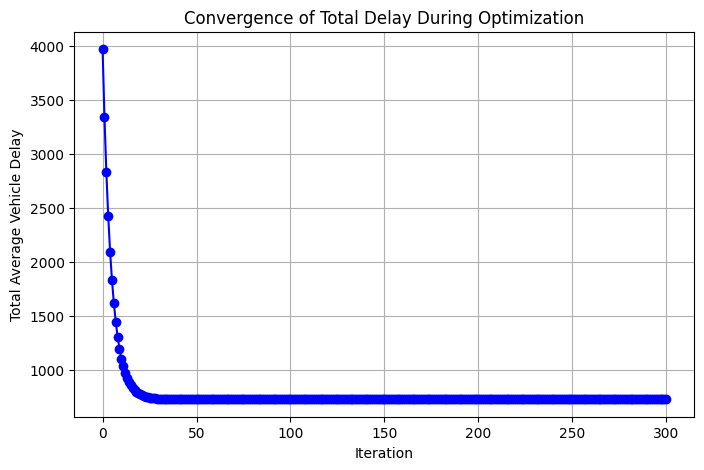

In [14]:
# Plot convergence graph
plt.figure(figsize=(8,5))
plt.plot(delay_hist, marker='o', color='blue')
plt.title('Convergence of Total Delay During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Total Average Vehicle Delay')
plt.grid(True)
plt.show()